In [1]:
from google.colab import files
uploaded = files.upload()

Saving international-airline-passengers.csv to international-airline-passengers.csv


In [2]:
from google.colab import files
uploaded = files.upload()

Saving monthly-car-sales-in-quebec-1960.csv to monthly-car-sales-in-quebec-1960.csv
Saving monthly-sales-of-company-x-jan-6.csv to monthly-sales-of-company-x-jan-6.csv


In [3]:
from google.colab import files
uploaded = files.upload()

Saving ._Series to ._Series


In [4]:
from google.colab import files
uploaded = files.upload()

Saving ._daily-total-female-births-in-cal.csv to ._daily-total-female-births-in-cal.csv
Saving ._international-airline-passengers.csv to ._international-airline-passengers.csv
Saving ._mean-monthly-air-temperature-deg.csv to ._mean-monthly-air-temperature-deg.csv
Saving ._monthly-boston-armed-robberies-j.csv to ._monthly-boston-armed-robberies-j.csv
Saving ._monthly-sales-of-company-x-jan-6.csv to ._monthly-sales-of-company-x-jan-6.csv
Saving ._weekly-closings-of-the-dowjones-.csv to ._weekly-closings-of-the-dowjones-.csv


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
car_sales = pd.read_csv('monthly-car-sales-in-quebec-1960.csv')

In [7]:
car_sales = car_sales.iloc[:,1]

In [8]:
def test_stationarity(timeseries,print_type='all'):
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    if print_type=='all':
        print('Results of Dickey-Fuller Test:')
        print(dfoutput)
    else: 
        return dfoutput['p-value']
    
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    majorLocator = MultipleLocator(20)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(5)
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        ts_ax.tick_params(which='minor', length=7, color='r')
        ts_ax.xaxis.set_minor_locator(minorLocator)
    return

Results of Dickey-Fuller Test:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


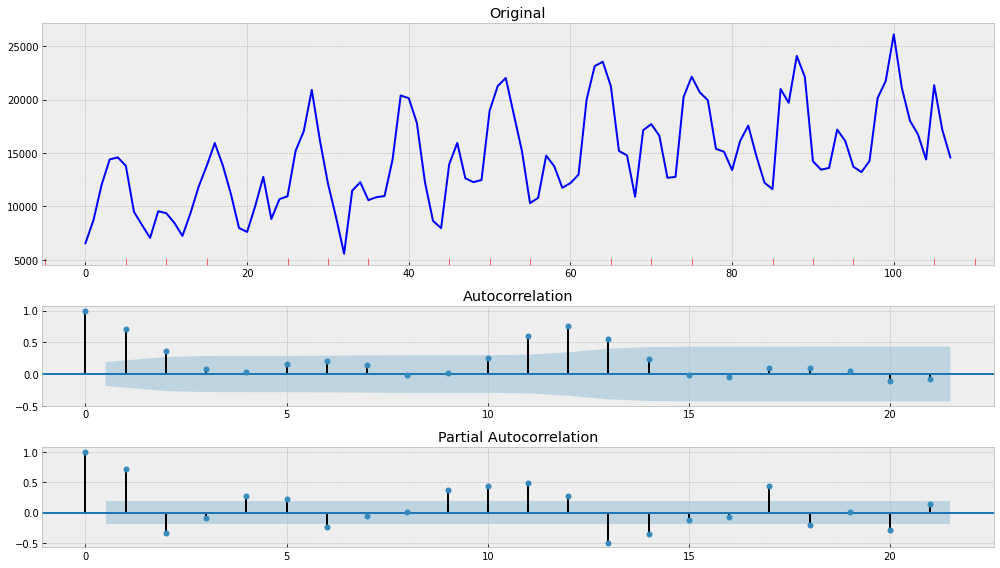

In [9]:
tsplot(car_sales)

Метод Бокса-Кокса

In [10]:
series = car_sales

Results of Dickey-Fuller Test:
Test Statistic                 -1.452425
p-value                         0.556901
#Lags Used                     13.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


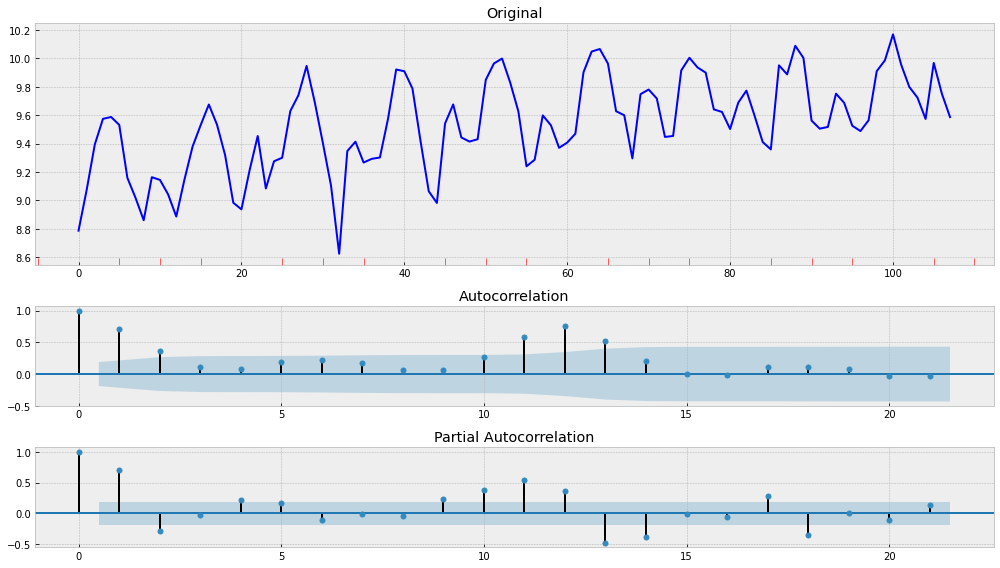

In [11]:
series=boxcox(series,0)
tsplot(series)

MA

In [12]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

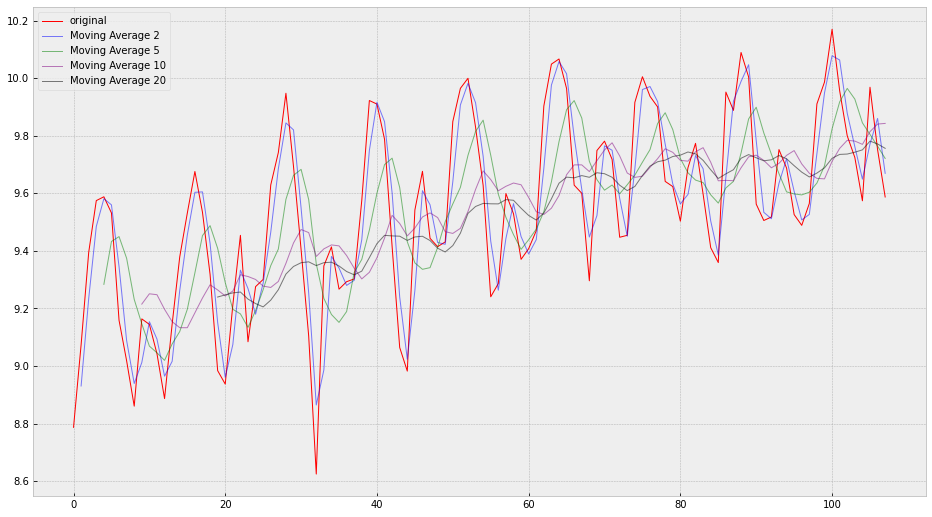

In [13]:
windows = [2,5,10,20]
colors = ['blue', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 9))
    plt.plot(series, color='red',label='original', linewidth='1')
    for i in range(len(windows)):
        ser = moving_average(series, windows[i])
        plt.plot(ser, color=colors[i], linewidth='1', alpha=0.5, label='Moving Average {}'.format(windows[i]))
    plt.legend()

Из графиков видим, что лучше всего самый лучший ряд получается - это ряд с большим окном

WMA

In [14]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [15]:
wma_fib = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(series, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(series, 7, [1,2,4,8,16,32,64])

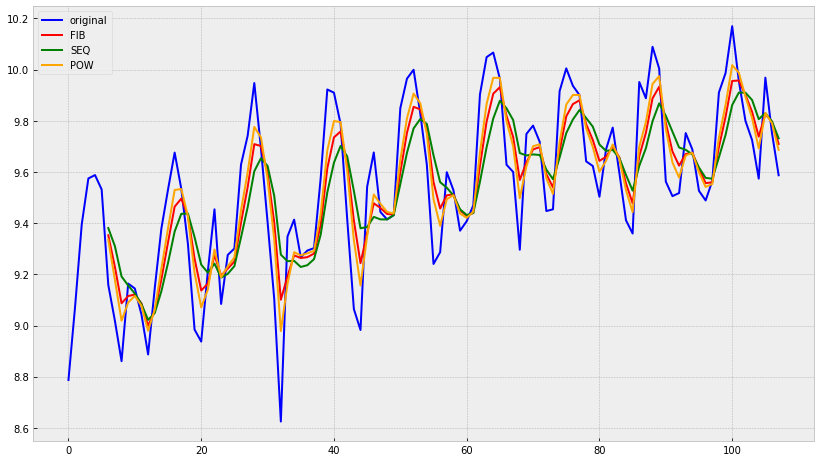

In [16]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    
    plt.plot(wma_fib, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW')
    plt.legend()


Скользящие не очень хорошо ловят экстремумы, но описывает в целом очень неплохо

EMA

In [17]:
train, val = series[:230], series[230:]

In [18]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

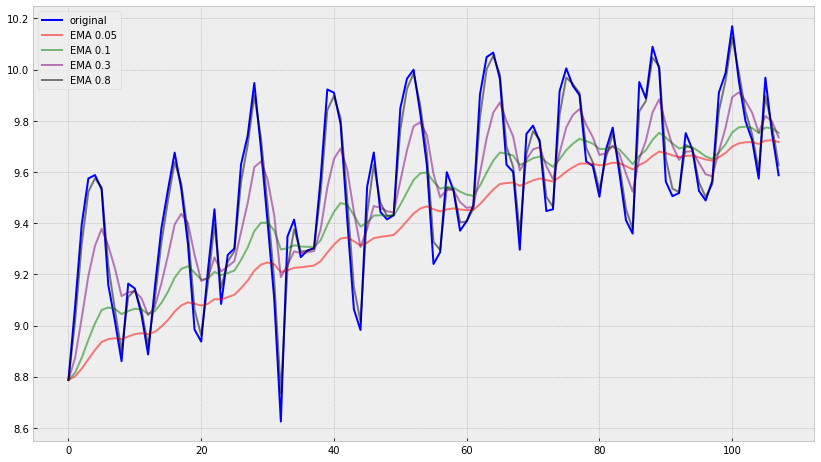

In [19]:

alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='EMA {}'.format(alphas[i]))
    plt.legend()

Хорошо прослеживается модель того, что чем больше мы опираемся на ближайшее наблюдение, тем точнее у нас получается предсказание

Alpha

In [20]:
def mse_cross_val(X):
    alpha= X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = exponential_moving_average(train[train_split],  alpha)
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, train[test_split])
        errors.append(error)
    return np.mean(np.array(errors))

In [21]:
opt = minimize(mse_cross_val, x0=[0], method="L-BFGS-B", bounds = ((0, 1),))

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

In [22]:
alpha_opt= opt.x
print(opt)

      fun: 0.159608120976603
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.94289029e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 34
      nit: 5
   status: 0
  success: True
        x: array([0.17425479])


In [23]:
def exponential_moving_average(series, alpha, n_pred=None):
    series=pd.DataFrame(train)[0]
    result = [series[0]]
    print(result)
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

[8.787220328629298]


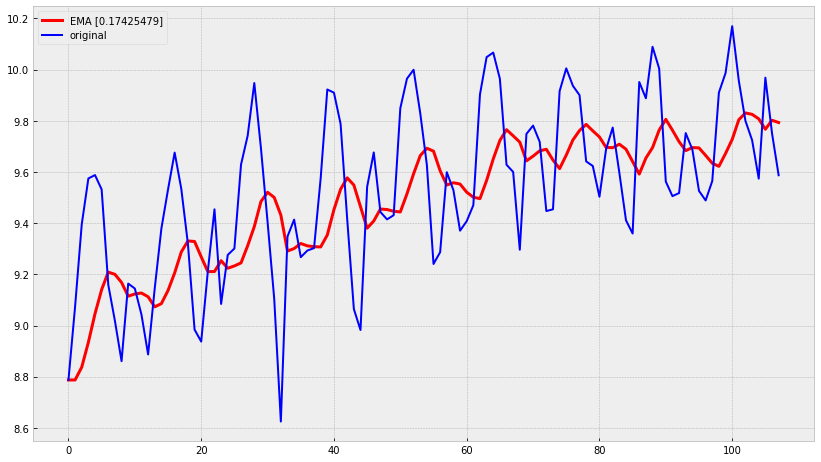

In [24]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    
    ser = exponential_moving_average(train, alpha_opt, len(val))
    plt.plot(ser, color='red', linewidth='3', label='EMA {}'.format(alpha_opt))
    plt.plot(series, color='blue',label='original')
    plt.legend()

Получаем неудовлетворительный результат

DEMA

In [25]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

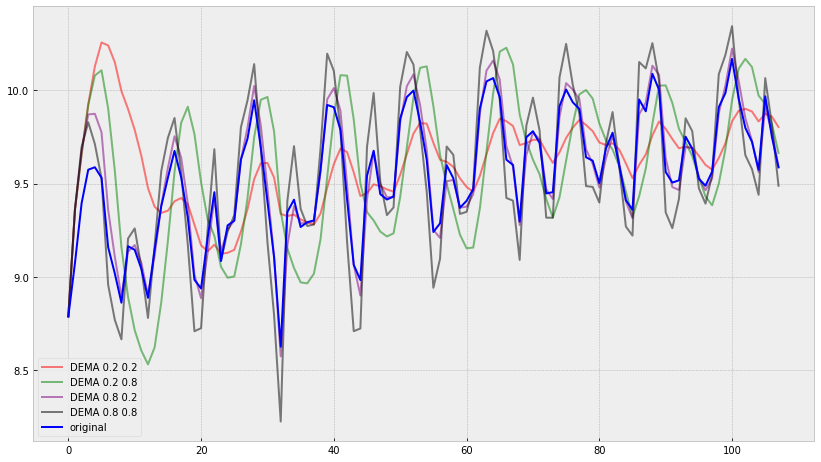

In [26]:

alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser = double_ema(series, alphas[i], bettas[i])
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

DEMA слишком чувствительна к параметрам и получаем такой же результат

In [27]:
def mse_cross_val(X):
    alpha, beta= X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = double_ema(train[train_split],  alpha, beta)
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, train[test_split])
        errors.append(error)
        #print(error)
    return np.mean(np.array(errors))

In [28]:
opt = minimize(mse_cross_val, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [29]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 0.17870550425310383
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.91353616e-07, -1.07913678e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 102
      nit: 23
   status: 0
  success: True
        x: array([0.46645701, 0.03691848])


In [30]:
def plot_dema(alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [31]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    series=pd.DataFrame(train)[0]
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


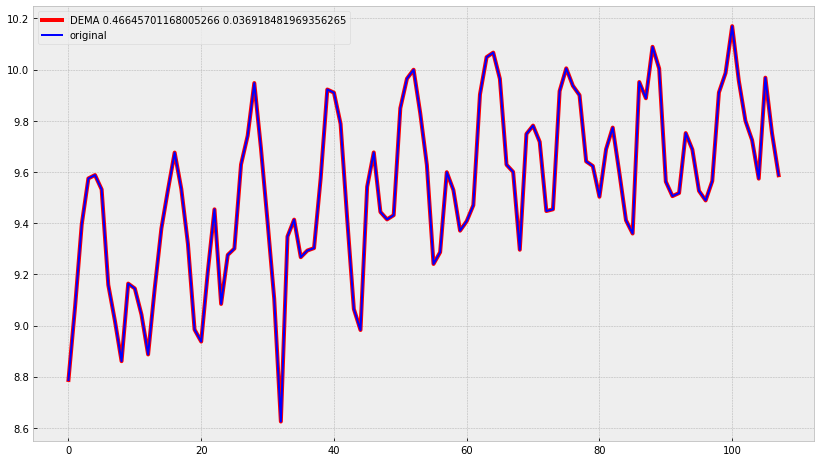

In [32]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    ser, _ = double_ema_with_preds(train, alpha_opt, beta_opt, len(val))
    plt.plot(ser, color='red', linewidth='4', label='DEMA {} {}'.format(alpha_opt, beta_opt))
    plt.plot(series, color='blue',label='original')
    plt.legend()

Теперь то, что нам надо 

**TEMA**

In [34]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

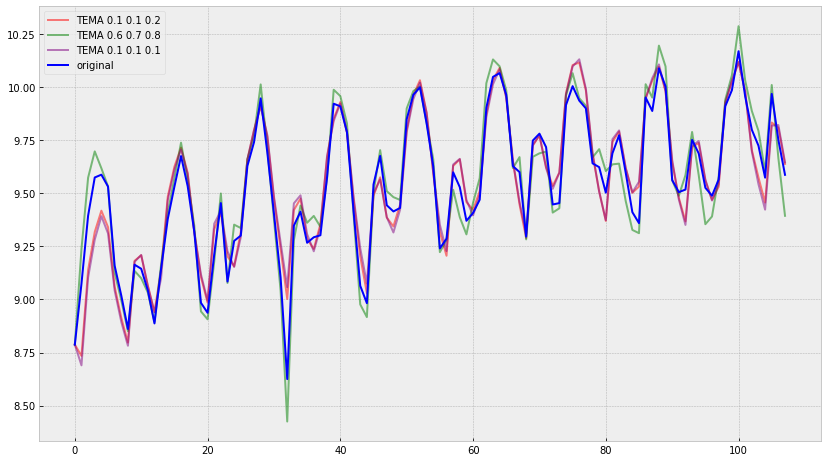

In [35]:

alphas = [0.1,0.6,0.1]
bettas = [0.1,0.7,0.1]
gammas = [0.2,0.8,0.1]
colors = ['red', 'green', 'purple', 'black']

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser = triple_exponential_smoothing(series, 12, alphas[i], bettas[i], gammas[i],  0)
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='TEMA {} {} {}'.format(alphas[i], bettas[i], gammas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

In [36]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA', alpha=0.5)
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [37]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [38]:
train, val = series[:214], series[214:]

In [39]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [40]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 5.552518414895024e-05
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.38955374e-05, -5.55768918e-05,  2.67400034e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 276
      nit: 51
   status: 0
  success: True
        x: array([0.04881338, 0.24454809, 0.95996521])


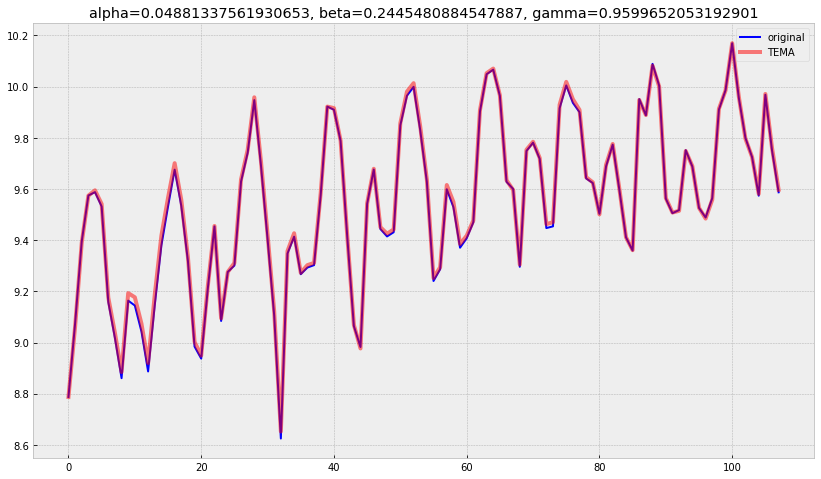

In [42]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

Отличный результат по DEMA

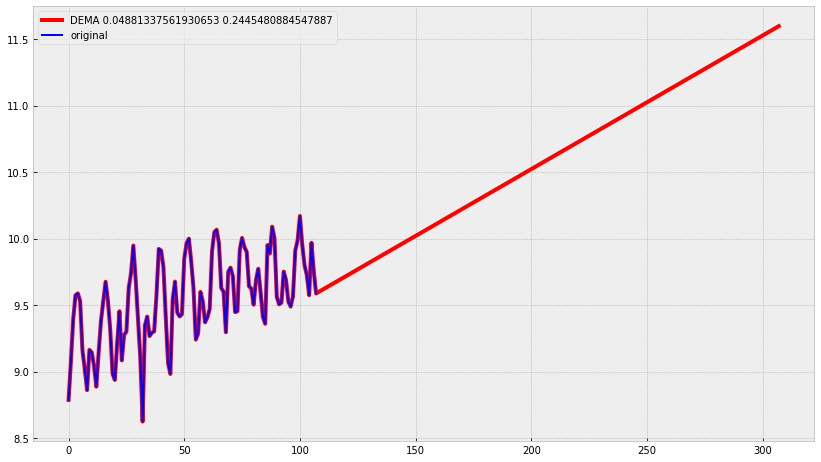

In [43]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    ser, _ = double_ema_with_preds(train, alpha_opt, beta_opt, len(val)+200)
    plt.plot(ser, color='red', linewidth='4', label='DEMA {} {}'.format(alpha_opt, beta_opt))
    plt.plot(series, color='blue',label='original')
    plt.legend()

В стационарном состоянии ужасный показатель

In [44]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [45]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [46]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 5.552518414895024e-05
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.38955374e-05, -5.55768918e-05,  2.67400034e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 276
      nit: 51
   status: 0
  success: True
        x: array([0.04881338, 0.24454809, 0.95996521])


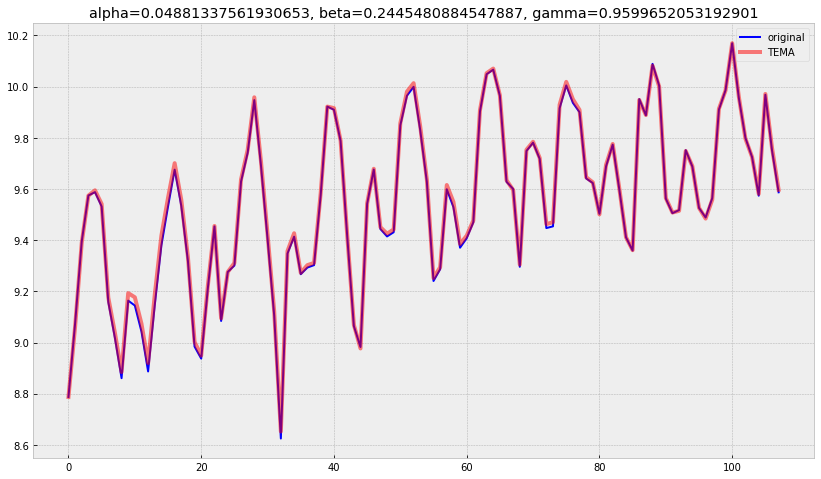

In [47]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

Получили хорошие предсказания очень близкие к оригиналу.

Большая часть моделей MA получаются достаточно достоверными и на них можно опираться.